# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](https://github.com/xlnwel/deep-learning/blob/master/embeddings/assets/one_hot_encoding.png?raw=1)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](https://github.com/xlnwel/deep-learning/blob/master/embeddings/assets/lookup_matrix.png?raw=1)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='https://github.com/xlnwel/deep-learning/blob/master/embeddings/assets/tokenize_lookup.png?raw=1' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="https://github.com/xlnwel/deep-learning/blob/master/embeddings/assets/word2vec_architectures.png?raw=1" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [29]:
!git clone https://github.com/xlnwel/deep-learning.git
%cd deep-learning/embeddings

Cloning into 'deep-learning'...
remote: Counting objects: 1463, done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1463 (delta 0), reused 0 (delta 0), pack-reused 1458
Receiving objects: 100% (1463/1463), 78.78 MiB | 37.33 MiB/s, done.
Resolving deltas: 100% (616/616), done.
/content/deep-learning/embeddings/deep-learning/embeddings


In [0]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [31]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
!pip install tqdm
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

Text8 Dataset: 31.4MB [00:14, 2.10MB/s]                            


## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [32]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [33]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to convert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [0]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [35]:
## Your code here
from collections import Counter
import random
from math import sqrt

t = 1e-3
print(len(int_words))
word_frequencies = Counter(int_words)
total = len(int_words)
drop_rate = {word: 1 - sqrt(t/count*total) for word, count in word_frequencies.items()}
train_words = [word for word in int_words if random.random() > drop_rate[word]]
print(len(train_words))

16680599
11660925


## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

In [0]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    # Your code here
    R = random.randint(1, window_size)

    targets = set(words[idx-R if idx-R > 0 else 0: idx] + words[idx: idx+R])
    return list(targets)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [0]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](https://github.com/xlnwel/deep-learning/blob/master/embeddings/assets/skip_gram_net_arch.png?raw=1)

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [0]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None])
    labels = tf.placeholder(tf.int32, None)

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [0]:
n_vocab = len(int_to_vocab)
n_embedding =  200
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding)))
    embed = tf.nn.embedding_lookup(embedding, inputs) # use tf.nn.embedding_lookup to get the hidden layer output

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [0]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding)))
    softmax_b = tf.Variable(tf.zeros(n_vocab))# create softmax biases here
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, 
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [43]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [45]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 17.5885 0.0373 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 15.3804 0.0295 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 13.8324 0.0301 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 13.2299 0.0290 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 11.9772 0.0292 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 11.5877 0.0297 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 11.3417 0.0303 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 10.8513 0.0295 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 10.8905 0.0300 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 10.3791 0.0301 sec/batch
Nearest to will: positronic, pp, saxon, be, galilee, hironaka, much, loathing,
Nearest to s: did, eradicated, archipelagoes, quiet, lsp, urogenital, hated, positions,
Nearest to seven: created, westcott, iconography, finely, has, stratton, except, king,
Nearest to world: ourense, foundrie

Epoch 1/10 Iteration: 3500 Avg. Training loss: 8.4205 0.0297 sec/batch
Epoch 1/10 Iteration: 3600 Avg. Training loss: 8.1570 0.0310 sec/batch
Epoch 1/10 Iteration: 3700 Avg. Training loss: 8.1061 0.0311 sec/batch
Epoch 1/10 Iteration: 3800 Avg. Training loss: 8.0109 0.0299 sec/batch
Epoch 1/10 Iteration: 3900 Avg. Training loss: 8.0663 0.0304 sec/batch
Epoch 1/10 Iteration: 4000 Avg. Training loss: 7.5838 0.0305 sec/batch
Nearest to will: be, that, to, on, of, a, only, have,
Nearest to s: this, in, the, of, and, to, for, a,
Nearest to seven: zero, two, five, on, four, three, eight, in,
Nearest to world: in, a, of, the, when, to, on, from,
Nearest to history: in, to, the, a, was, of, by, but,
Nearest to as: a, in, the, for, which, of, to, on,
Nearest to often: most, that, is, but, as, to, the, a,
Nearest to his: most, the, and, also, of, on, in, to,
Nearest to san: much, with, the, to, they, created, including, six,
Nearest to nobel: many, century, these, because, also, most, was, their

Epoch 1/10 Iteration: 6900 Avg. Training loss: 6.8886 0.0301 sec/batch
Epoch 1/10 Iteration: 7000 Avg. Training loss: 7.0503 0.0305 sec/batch
Nearest to will: so, all, be, them, would, same, they, thus,
Nearest to s: the, was, on, after, in, of, from, when,
Nearest to seven: five, eight, six, one, four, nine, zero, three,
Nearest to world: around, after, since, he, until, war, during, long,
Nearest to history: early, work, much, life, long, until, over, important,
Nearest to as: such, well, known, a, that, this, is, the,
Nearest to often: used, most, but, called, or, these, however, is,
Nearest to his: he, after, work, own, later, early, him, while,
Nearest to san: man, around, much, just, created, under, united, life,
Nearest to nobel: century, us, late, half, end, factors, work, make,
Nearest to heavy: around, smaller, provide, much, works, earlier, free, either,
Nearest to grand: countries, i, related, king, home, though, against, said,
Nearest to police: study, around, having, out,

Epoch 1/10 Iteration: 9900 Avg. Training loss: 6.1657 0.0293 sec/batch
Epoch 1/10 Iteration: 10000 Avg. Training loss: 6.5061 0.0295 sec/batch
Nearest to will: make, if, each, does, must, thus, always, because,
Nearest to s: the, in, of, and, from, a, to, was,
Nearest to seven: eight, one, six, nine, five, four, three, zero,
Nearest to world: ii, war, end, during, around, until, according, third,
Nearest to history: official, article, century, important, life, today, study, sources,
Nearest to as: well, such, known, a, the, of, but, and,
Nearest to often: is, used, most, the, since, it, usually, sometimes,
Nearest to his: he, him, work, was, made, later, time, after,
Nearest to san: study, sent, future, established, itself, expanded, public, includes,
Nearest to nobel: prize, german, subsequent, british, written, french, opened, series,
Nearest to heavy: free, human, therefore, systems, smaller, set, countries, always,
Nearest to grand: countries, makes, king, central, largely, here, t

Epoch 2/10 Iteration: 12800 Avg. Training loss: 6.0989 0.0296 sec/batch
Epoch 2/10 Iteration: 12900 Avg. Training loss: 6.1547 0.0302 sec/batch
Epoch 2/10 Iteration: 13000 Avg. Training loss: 6.1782 0.0302 sec/batch
Nearest to will: that, all, make, to, it, they, this, be,
Nearest to s: the, in, of, on, was, and, a, to,
Nearest to seven: one, nine, eight, six, five, three, four, two,
Nearest to world: war, during, ii, the, in, around, to, of,
Nearest to history: early, style, today, ancient, record, important, of, culture,
Nearest to as: such, well, is, known, the, a, of, that,
Nearest to often: most, is, used, are, the, with, even, to,
Nearest to his: he, was, him, the, of, in, after, died,
Nearest to san: francisco, prior, running, future, city, currently, women, record,
Nearest to nobel: prize, chemist, laureate, physicist, recipient, peace, german, british,
Nearest to heavy: purposes, invasion, perceived, constructed, controversial, lack, represent, agreement,
Nearest to grand: nat

Epoch 2/10 Iteration: 15800 Avg. Training loss: 5.9094 0.0305 sec/batch
Epoch 2/10 Iteration: 15900 Avg. Training loss: 5.8801 0.0305 sec/batch
Epoch 2/10 Iteration: 16000 Avg. Training loss: 5.7415 0.0305 sec/batch
Nearest to will: that, it, be, they, to, is, this, but,
Nearest to s: zero, one, the, two, nine, seven, in, four,
Nearest to seven: one, eight, nine, five, six, zero, four, two,
Nearest to world: war, the, ii, during, around, of, in, and,
Nearest to history: early, of, the, about, century, article, ancient, important,
Nearest to as: such, well, a, the, is, known, to, but,
Nearest to often: used, is, most, are, or, usually, as, that,
Nearest to his: he, was, him, the, to, with, on, life,
Nearest to san: francisco, replace, diego, street, bay, california, running, places,
Nearest to nobel: prize, laureate, chemist, recipient, physicist, winners, swiss, eric,
Nearest to heavy: money, round, represent, perceived, bodies, practical, invasion, producing,
Nearest to grand: emerged

Epoch 2/10 Iteration: 18800 Avg. Training loss: 5.6814 0.0306 sec/batch
Epoch 2/10 Iteration: 18900 Avg. Training loss: 5.5392 0.0303 sec/batch
Epoch 2/10 Iteration: 19000 Avg. Training loss: 5.4225 0.0302 sec/batch
Nearest to will: make, that, be, it, this, to, they, if,
Nearest to s: the, in, of, one, by, and, nine, u,
Nearest to seven: nine, one, eight, six, three, five, four, two,
Nearest to world: war, ii, the, of, during, in, major, new,
Nearest to history: of, the, study, article, early, historical, and, in,
Nearest to as: such, well, known, a, this, is, the, to,
Nearest to often: is, are, used, this, most, or, term, to,
Nearest to his: he, was, death, the, him, life, later, first,
Nearest to san: francisco, california, diego, running, completed, recorded, centre, street,
Nearest to nobel: prize, physicist, laureate, chemist, recipient, winners, medicine, physiology,
Nearest to heavy: perceived, cost, metal, money, room, expensive, requirements, charge,
Nearest to grand: weapons

Epoch 2/10 Iteration: 21800 Avg. Training loss: 5.6774 0.0299 sec/batch
Epoch 2/10 Iteration: 21900 Avg. Training loss: 5.5520 0.0295 sec/batch
Epoch 2/10 Iteration: 22000 Avg. Training loss: 5.6049 0.0295 sec/batch
Nearest to will: make, be, we, that, it, is, so, they,
Nearest to s: the, by, a, in, and, of, u, from,
Nearest to seven: six, one, nine, eight, five, four, two, three,
Nearest to world: war, the, during, country, of, in, and, from,
Nearest to history: of, the, in, country, and, world, modern, times,
Nearest to as: well, such, known, is, a, the, but, and,
Nearest to often: is, used, are, more, referred, that, different, it,
Nearest to his: he, him, was, death, father, after, life, had,
Nearest to san: francisco, california, city, final, in, events, usa, home,
Nearest to nobel: prize, laureate, chemist, recipient, medicine, physicist, physiology, winners,
Nearest to heavy: metal, permitted, ordinary, requirements, weight, money, expensive, cost,
Nearest to grand: duke, money,

Epoch 3/10 Iteration: 24800 Avg. Training loss: 5.1995 0.0301 sec/batch
Epoch 3/10 Iteration: 24900 Avg. Training loss: 5.2690 0.0309 sec/batch
Epoch 3/10 Iteration: 25000 Avg. Training loss: 5.1189 0.0301 sec/batch
Nearest to will: they, be, that, it, to, make, not, come,
Nearest to s: the, u, in, of, was, and, zero, nine,
Nearest to seven: one, eight, nine, six, five, four, three, zero,
Nearest to world: war, the, during, in, of, country, its, s,
Nearest to history: of, culture, the, article, early, first, see, in,
Nearest to as: well, such, known, for, that, this, a, and,
Nearest to often: most, are, or, used, common, because, is, that,
Nearest to his: he, was, him, father, before, death, life, after,
Nearest to san: california, francisco, city, one, nine, the, in, eight,
Nearest to nobel: prize, physicist, laureate, chemist, recipient, scientist, physiology, swiss,
Nearest to heavy: metal, table, cut, bound, overall, ones, understanding, cost,
Nearest to grand: duke, figure, final,

Epoch 3/10 Iteration: 27800 Avg. Training loss: 5.1035 0.0308 sec/batch
Epoch 3/10 Iteration: 27900 Avg. Training loss: 5.1622 0.0308 sec/batch
Epoch 3/10 Iteration: 28000 Avg. Training loss: 5.3351 0.0316 sec/batch
Nearest to will: be, that, it, not, make, can, if, to,
Nearest to s: the, u, early, zero, in, and, of, was,
Nearest to seven: eight, nine, one, six, four, five, three, zero,
Nearest to world: war, during, the, in, of, and, started, ii,
Nearest to history: early, of, in, the, today, s, museum, world,
Nearest to as: well, such, known, a, the, of, is, an,
Nearest to often: used, is, are, or, sometimes, different, usually, other,
Nearest to his: he, him, was, father, had, who, life, died,
Nearest to san: francisco, california, city, bay, county, london, located, west,
Nearest to nobel: prize, laureate, physicist, chemist, recipient, mathematician, physiology, swiss,
Nearest to heavy: to, metal, low, better, provide, with, most, water,
Nearest to grand: ended, game, british, fin

Epoch 3/10 Iteration: 30800 Avg. Training loss: 5.0587 0.0307 sec/batch
Epoch 3/10 Iteration: 30900 Avg. Training loss: 4.9913 0.0301 sec/batch
Epoch 3/10 Iteration: 31000 Avg. Training loss: 5.0466 0.0301 sec/batch
Nearest to will: if, be, they, make, that, it, can, not,
Nearest to s: the, in, of, was, by, u, and, nine,
Nearest to seven: one, nine, six, eight, five, four, three, two,
Nearest to world: war, the, of, in, during, country, s, started,
Nearest to history: of, article, modern, the, ancient, in, world, references,
Nearest to as: well, such, known, the, this, a, is, in,
Nearest to often: is, used, are, different, most, this, or, very,
Nearest to his: he, father, him, career, was, wife, death, life,
Nearest to san: francisco, california, in, nine, one, city, town, six,
Nearest to nobel: prize, physicist, laureate, writer, scientist, literature, american, chemist,
Nearest to heavy: metal, with, sound, even, still, or, found, music,
Nearest to grand: of, one, duke, nine, great, 

Epoch 3/10 Iteration: 33900 Avg. Training loss: 4.9477 0.0298 sec/batch
Epoch 3/10 Iteration: 34000 Avg. Training loss: 4.7794 0.0298 sec/batch
Nearest to will: be, do, that, can, because, they, it, this,
Nearest to s: u, one, in, nine, the, five, eight, of,
Nearest to seven: eight, six, nine, one, five, four, three, two,
Nearest to world: war, the, in, of, s, country, during, its,
Nearest to history: of, modern, see, ancient, early, earliest, and, english,
Nearest to as: well, such, known, of, is, a, the, in,
Nearest to often: is, used, are, that, be, different, very, these,
Nearest to his: he, him, father, himself, mother, was, career, wife,
Nearest to san: francisco, california, los, city, built, street, santa, mexico,
Nearest to nobel: prize, physicist, writer, chemist, swiss, american, scientist, politician,
Nearest to heavy: metal, very, are, there, a, is, range, pure,
Nearest to grand: duke, march, winning, october, one, first, nine, subsequently,
Nearest to police: army, force,

Epoch 4/10 Iteration: 36900 Avg. Training loss: 4.8832 0.0297 sec/batch
Epoch 4/10 Iteration: 37000 Avg. Training loss: 4.8861 0.0298 sec/batch
Nearest to will: be, to, any, it, could, that, if, they,
Nearest to s: the, in, early, u, by, one, was, on,
Nearest to seven: nine, eight, one, six, four, three, five, two,
Nearest to world: war, during, the, in, post, s, series, second,
Nearest to history: early, of, references, see, s, english, in, historical,
Nearest to as: well, such, known, regarded, the, a, is, and,
Nearest to often: used, usually, is, are, this, sometimes, or, these,
Nearest to his: he, him, father, was, death, last, life, had,
Nearest to san: francisco, california, diego, nine, university, one, seven, los,
Nearest to nobel: prize, physicist, chemist, recipient, swiss, writer, laureate, scientist,
Nearest to heavy: light, a, metal, large, and, an, the, through,
Nearest to grand: duke, prince, nine, one, king, ii, march, eight,
Nearest to police: state, the, government, m

Epoch 4/10 Iteration: 39900 Avg. Training loss: 4.8769 0.0299 sec/batch
Epoch 4/10 Iteration: 40000 Avg. Training loss: 4.6550 0.0302 sec/batch
Nearest to will: be, make, it, if, that, always, not, would,
Nearest to s: one, the, nine, zero, by, was, and, of,
Nearest to seven: nine, eight, one, six, four, five, three, two,
Nearest to world: war, the, around, of, during, in, country, and,
Nearest to history: of, historical, early, article, s, external, in, links,
Nearest to as: well, such, known, of, the, is, a, and,
Nearest to often: used, is, sometimes, are, referred, or, such, this,
Nearest to his: he, him, father, was, wife, who, had, career,
Nearest to san: francisco, diego, california, bay, los, city, county, juan,
Nearest to nobel: prize, physicist, chemist, laureate, writer, swiss, d, american,
Nearest to heavy: metal, very, with, to, more, these, low, better,
Nearest to grand: duke, british, nine, london, eight, seven, one, george,
Nearest to police: forces, government, against,

Epoch 4/10 Iteration: 42800 Avg. Training loss: 4.7678 0.0304 sec/batch
Epoch 4/10 Iteration: 42900 Avg. Training loss: 4.8198 0.0304 sec/batch
Epoch 4/10 Iteration: 43000 Avg. Training loss: 4.8742 0.0298 sec/batch
Nearest to will: be, make, if, do, they, so, it, you,
Nearest to s: was, one, by, nine, the, zero, his, u,
Nearest to seven: nine, one, eight, six, five, four, three, two,
Nearest to world: war, throughout, during, the, end, country, in, around,
Nearest to history: article, see, museum, external, ancient, timeline, historical, culture,
Nearest to as: well, such, known, the, seen, is, other, some,
Nearest to often: is, are, used, very, sometimes, more, some, usually,
Nearest to his: he, him, father, death, was, wife, had, her,
Nearest to san: francisco, diego, california, city, park, antonio, york, los,
Nearest to nobel: prize, chemist, physicist, awarded, laureate, swiss, scientist, writer,
Nearest to heavy: metal, light, small, water, a, like, somewhat, very,
Nearest to gr

Epoch 4/10 Iteration: 45800 Avg. Training loss: 4.7928 0.0293 sec/batch
Epoch 4/10 Iteration: 45900 Avg. Training loss: 4.6037 0.0298 sec/batch
Epoch 4/10 Iteration: 46000 Avg. Training loss: 4.6153 0.0299 sec/batch
Nearest to will: be, must, if, that, it, this, to, you,
Nearest to s: the, u, by, of, in, on, and, a,
Nearest to seven: eight, one, nine, six, five, four, three, two,
Nearest to world: war, ii, during, the, in, germany, first, of,
Nearest to history: of, early, ancient, article, modern, pre, see, culture,
Nearest to as: well, such, known, the, it, a, but, is,
Nearest to often: usually, used, are, or, sometimes, is, describe, forms,
Nearest to his: he, father, himself, him, wife, friends, was, son,
Nearest to san: francisco, diego, california, antonio, angeles, santa, los, juan,
Nearest to nobel: prize, laureate, chemist, physicist, writer, recipient, physician, d,
Nearest to heavy: metal, very, with, due, too, greatly, its, high,
Nearest to grand: duke, british, henry, king

Epoch 5/10 Iteration: 48800 Avg. Training loss: 4.6502 0.0297 sec/batch
Epoch 5/10 Iteration: 48900 Avg. Training loss: 4.7085 0.0298 sec/batch
Epoch 5/10 Iteration: 49000 Avg. Training loss: 4.7309 0.0295 sec/batch
Nearest to will: be, they, to, make, if, not, keep, would,
Nearest to s: the, u, nine, after, was, by, one, his,
Nearest to seven: nine, four, eight, one, six, five, three, zero,
Nearest to world: war, series, first, during, around, the, in, s,
Nearest to history: of, see, origins, ancient, museum, references, early, the,
Nearest to as: well, known, such, a, the, and, this, is,
Nearest to often: used, sometimes, usually, is, are, or, such, more,
Nearest to his: he, him, father, her, wife, himself, died, who,
Nearest to san: francisco, diego, california, angeles, los, park, jose, bay,
Nearest to nobel: prize, laureate, chemist, physicist, recipient, writer, scientist, inventor,
Nearest to heavy: metal, light, better, lead, the, weight, and, high,
Nearest to grand: duke, nine

Epoch 5/10 Iteration: 51800 Avg. Training loss: 4.5940 0.0300 sec/batch
Epoch 5/10 Iteration: 51900 Avg. Training loss: 4.5371 0.0301 sec/batch
Epoch 5/10 Iteration: 52000 Avg. Training loss: 4.6378 0.0298 sec/batch
Nearest to will: be, must, if, they, make, need, get, can,
Nearest to s: u, the, by, one, zero, of, three, in,
Nearest to seven: nine, eight, one, six, four, five, three, two,
Nearest to world: war, ii, the, during, country, in, around, of,
Nearest to history: early, historical, of, article, museum, politics, external, new,
Nearest to as: well, such, known, regarded, a, is, this, the,
Nearest to often: used, sometimes, usually, are, or, describe, considered, is,
Nearest to his: he, father, him, her, wife, himself, wrote, mother,
Nearest to san: francisco, california, diego, jose, bay, los, st, santa,
Nearest to nobel: prize, laureate, chemist, physicist, writer, alfred, american, austrian,
Nearest to heavy: metal, water, low, weight, expensive, high, relatively, caused,
Nea

Epoch 5/10 Iteration: 54800 Avg. Training loss: 4.4669 0.0312 sec/batch
Epoch 5/10 Iteration: 54900 Avg. Training loss: 4.4799 0.0310 sec/batch
Epoch 5/10 Iteration: 55000 Avg. Training loss: 4.5535 0.0315 sec/batch
Nearest to will: be, if, that, it, need, make, do, this,
Nearest to s: u, the, one, of, in, by, nine, us,
Nearest to seven: nine, six, one, four, eight, five, three, zero,
Nearest to world: largest, country, countries, war, the, throughout, in, europe,
Nearest to history: historical, timeline, article, origins, of, see, main, comprehensive,
Nearest to as: such, well, known, referred, is, the, a, some,
Nearest to often: used, are, some, usually, or, quite, more, sometimes,
Nearest to his: he, father, him, wife, her, himself, mother, death,
Nearest to san: francisco, diego, california, antonio, jose, santa, city, memorial,
Nearest to nobel: prize, laureate, chemist, physicist, winners, physiology, writer, scientist,
Nearest to heavy: metal, very, water, deep, larger, cut, sma

Epoch 5/10 Iteration: 57800 Avg. Training loss: 4.5469 0.0304 sec/batch
Epoch 5/10 Iteration: 57900 Avg. Training loss: 4.5623 0.0304 sec/batch
Epoch 5/10 Iteration: 58000 Avg. Training loss: 4.5321 0.0302 sec/batch
Nearest to will: be, if, you, make, get, enough, must, your,
Nearest to s: u, the, in, by, first, zero, and, was,
Nearest to seven: one, nine, eight, four, five, six, three, two,
Nearest to world: war, during, the, ii, largest, second, s, in,
Nearest to history: timeline, links, article, historical, of, museum, external, site,
Nearest to as: well, such, known, a, the, referred, is, seen,
Nearest to often: usually, used, are, quite, or, typically, frequently, more,
Nearest to his: he, him, her, father, wife, himself, friend, son,
Nearest to san: francisco, diego, california, antonio, juan, jose, angeles, los,
Nearest to nobel: prize, laureate, physicist, recipient, chemist, physiology, writer, d,
Nearest to heavy: metal, very, due, made, low, steel, cut, with,
Nearest to gra

Epoch 6/10 Iteration: 60800 Avg. Training loss: 4.5365 0.0304 sec/batch
Epoch 6/10 Iteration: 60900 Avg. Training loss: 4.5170 0.0304 sec/batch
Epoch 6/10 Iteration: 61000 Avg. Training loss: 4.3904 0.0302 sec/batch
Nearest to will: if, make, unless, give, they, be, you, your,
Nearest to s: u, the, world, nine, in, was, on, by,
Nearest to seven: four, one, five, six, eight, nine, zero, three,
Nearest to world: war, during, largest, second, the, s, in, united,
Nearest to history: historical, culture, origins, of, early, museum, timeline, world,
Nearest to as: well, such, known, the, regarded, of, and, in,
Nearest to often: used, are, is, sometimes, usually, different, typically, considered,
Nearest to his: he, him, himself, father, wife, was, career, died,
Nearest to san: francisco, diego, california, antonio, jose, los, angeles, texas,
Nearest to nobel: prize, laureate, recipient, physicist, chemist, scientist, physiology, inventor,
Nearest to heavy: metal, vehicles, mounted, light, fa

Epoch 6/10 Iteration: 63700 Avg. Training loss: 4.4713 0.0299 sec/batch
Epoch 6/10 Iteration: 63800 Avg. Training loss: 4.4545 0.0304 sec/batch
Epoch 6/10 Iteration: 63900 Avg. Training loss: 4.5014 0.0302 sec/batch
Epoch 6/10 Iteration: 64000 Avg. Training loss: 4.5141 0.0301 sec/batch
Nearest to will: must, be, get, if, it, that, make, way,
Nearest to s: nine, one, the, was, and, his, in, on,
Nearest to seven: nine, eight, six, one, four, five, three, zero,
Nearest to world: war, ii, the, post, throughout, country, major, during,
Nearest to history: modern, historical, origins, early, of, links, article, culture,
Nearest to as: well, such, known, referred, opposed, often, some, is,
Nearest to often: sometimes, describe, used, as, are, considered, term, is,
Nearest to his: he, father, wife, death, himself, was, mother, him,
Nearest to san: francisco, diego, california, jose, los, bay, angeles, santa,
Nearest to nobel: prize, laureate, physicist, chemist, recipient, writer, hugo, austr

Epoch 6/10 Iteration: 66700 Avg. Training loss: 4.3962 0.0296 sec/batch
Epoch 6/10 Iteration: 66800 Avg. Training loss: 4.5012 0.0296 sec/batch
Epoch 6/10 Iteration: 66900 Avg. Training loss: 4.3906 0.0297 sec/batch
Epoch 6/10 Iteration: 67000 Avg. Training loss: 4.4487 0.0309 sec/batch
Nearest to will: can, be, if, do, or, not, it, make,
Nearest to s: u, the, nine, in, one, was, of, dr,
Nearest to seven: one, nine, five, six, eight, four, three, zero,
Nearest to world: war, throughout, largest, ii, the, country, during, around,
Nearest to history: timeline, of, medieval, historical, article, geography, comprehensive, museum,
Nearest to as: well, such, known, referred, viewed, a, the, by,
Nearest to often: sometimes, used, referred, usually, are, is, or, reasons,
Nearest to his: he, father, himself, him, wife, her, mother, career,
Nearest to san: francisco, diego, jose, antonio, california, santa, carlos, los,
Nearest to nobel: prize, laureate, winners, chemist, awarded, physiology, ph

Epoch 6/10 Iteration: 69700 Avg. Training loss: 4.4156 0.0304 sec/batch
Epoch 6/10 Iteration: 69800 Avg. Training loss: 4.4738 0.0303 sec/batch
Epoch 6/10 Iteration: 69900 Avg. Training loss: 4.4972 0.0303 sec/batch
Epoch 7/10 Iteration: 70000 Avg. Training loss: 4.4324 0.0130 sec/batch
Nearest to will: be, if, you, do, cannot, this, must, not,
Nearest to s: the, by, nine, one, u, his, of, on,
Nearest to seven: one, nine, eight, five, six, four, three, zero,
Nearest to world: the, war, in, around, during, of, ii, largest,
Nearest to history: timeline, see, of, historical, article, external, modern, links,
Nearest to as: well, such, known, being, viewed, a, and, the,
Nearest to often: sometimes, are, referred, used, is, quite, common, generally,
Nearest to his: he, father, him, himself, her, wife, own, brother,
Nearest to san: francisco, diego, jose, california, antonio, juan, los, fernando,
Nearest to nobel: prize, physicist, laureate, chemist, recipient, physiology, austrian, d,
Neare

Epoch 7/10 Iteration: 72700 Avg. Training loss: 4.2979 0.0307 sec/batch
Epoch 7/10 Iteration: 72800 Avg. Training loss: 4.2502 0.0306 sec/batch
Epoch 7/10 Iteration: 72900 Avg. Training loss: 4.2647 0.0307 sec/batch
Epoch 7/10 Iteration: 73000 Avg. Training loss: 4.3873 0.0307 sec/batch
Nearest to will: be, if, try, unless, need, make, get, continue,
Nearest to s: u, the, one, nine, of, in, by, world,
Nearest to seven: eight, five, four, six, one, three, nine, zero,
Nearest to world: war, the, largest, around, during, countries, history, major,
Nearest to history: article, see, geography, politics, of, links, origins, economy,
Nearest to as: such, well, known, regarded, are, often, some, of,
Nearest to often: sometimes, used, usually, are, as, different, cited, considered,
Nearest to his: he, him, father, himself, wife, career, her, mother,
Nearest to san: francisco, diego, jose, california, los, angeles, juan, bay,
Nearest to nobel: prize, laureate, physicist, chemist, recipient, econ

Epoch 7/10 Iteration: 75700 Avg. Training loss: 4.3840 0.0302 sec/batch
Epoch 7/10 Iteration: 75800 Avg. Training loss: 4.3113 0.0303 sec/batch
Epoch 7/10 Iteration: 75900 Avg. Training loss: 4.3214 0.0304 sec/batch
Epoch 7/10 Iteration: 76000 Avg. Training loss: 4.2659 0.0305 sec/batch
Nearest to will: be, if, get, to, do, need, would, make,
Nearest to s: u, the, and, zero, was, in, one, a,
Nearest to seven: one, nine, eight, six, four, three, five, d,
Nearest to world: war, ii, during, the, cup, nation, era, around,
Nearest to history: historical, links, cinema, origins, references, brief, see, external,
Nearest to as: well, such, known, regarded, referred, a, seen, sometimes,
Nearest to often: sometimes, used, usually, frequently, referred, as, are, describe,
Nearest to his: he, him, himself, father, wife, son, mother, her,
Nearest to san: francisco, california, jose, diego, los, juan, santa, bay,
Nearest to nobel: prize, laureate, chemist, physicist, physiology, recipient, writer, 

Epoch 7/10 Iteration: 78700 Avg. Training loss: 4.3034 0.0303 sec/batch
Epoch 7/10 Iteration: 78800 Avg. Training loss: 3.9993 0.0304 sec/batch
Epoch 7/10 Iteration: 78900 Avg. Training loss: 4.4197 0.0306 sec/batch
Epoch 7/10 Iteration: 79000 Avg. Training loss: 4.1562 0.0304 sec/batch
Nearest to will: if, your, you, be, do, must, say, we,
Nearest to s: u, john, the, his, and, dr, by, father,
Nearest to seven: one, eight, six, five, nine, three, four, d,
Nearest to world: war, ii, largest, the, around, during, germany, begins,
Nearest to history: historical, article, modern, origins, links, timeline, geography, external,
Nearest to as: well, known, such, regarded, referred, a, he, of,
Nearest to often: sometimes, used, referred, usually, quite, considered, rarely, are,
Nearest to his: he, career, father, was, himself, him, wife, work,
Nearest to san: francisco, diego, california, jose, santa, los, antonio, juan,
Nearest to nobel: prize, laureate, physicist, chemist, recipient, d, writ

Epoch 8/10 Iteration: 81700 Avg. Training loss: 4.3119 0.0252 sec/batch
Epoch 8/10 Iteration: 81800 Avg. Training loss: 4.4251 0.0305 sec/batch
Epoch 8/10 Iteration: 81900 Avg. Training loss: 4.3211 0.0307 sec/batch
Epoch 8/10 Iteration: 82000 Avg. Training loss: 4.2750 0.0306 sec/batch
Nearest to will: cannot, must, if, you, be, we, that, give,
Nearest to s: u, nine, one, by, the, zero, early, was,
Nearest to seven: eight, one, six, nine, five, four, three, two,
Nearest to world: war, history, the, largest, ii, around, europe, of,
Nearest to history: timeline, historical, article, origins, world, links, museum, detailed,
Nearest to as: such, well, known, referred, being, regarded, viewed, simply,
Nearest to often: frequently, referred, sometimes, usually, simply, quite, some, as,
Nearest to his: he, wife, himself, him, father, friend, career, mother,
Nearest to san: francisco, diego, california, antonio, angeles, los, jose, juan,
Nearest to nobel: prize, laureate, physicist, chemist, 

Epoch 8/10 Iteration: 84700 Avg. Training loss: 4.2326 0.0295 sec/batch
Epoch 8/10 Iteration: 84800 Avg. Training loss: 4.2437 0.0305 sec/batch
Epoch 8/10 Iteration: 84900 Avg. Training loss: 4.2316 0.0307 sec/batch
Epoch 8/10 Iteration: 85000 Avg. Training loss: 4.2268 0.0312 sec/batch
Nearest to will: be, must, cannot, unless, therefore, to, do, should,
Nearest to s: u, nine, the, one, eight, of, was, dr,
Nearest to seven: six, eight, one, five, four, nine, three, zero,
Nearest to world: war, largest, ii, heritage, around, america, biggest, the,
Nearest to history: article, politics, historical, of, origins, links, modern, see,
Nearest to as: such, well, referred, known, often, regarded, a, used,
Nearest to often: sometimes, used, as, referred, cited, associated, describe, term,
Nearest to his: he, him, wife, father, himself, career, died, daughter,
Nearest to san: francisco, diego, jose, california, los, juan, angeles, bay,
Nearest to nobel: prize, laureate, recipient, physicist, bi

Epoch 8/10 Iteration: 87700 Avg. Training loss: 4.2416 0.0304 sec/batch
Epoch 8/10 Iteration: 87800 Avg. Training loss: 4.3357 0.0304 sec/batch
Epoch 8/10 Iteration: 87900 Avg. Training loss: 4.2914 0.0305 sec/batch
Epoch 8/10 Iteration: 88000 Avg. Training loss: 4.2802 0.0306 sec/batch
Nearest to will: be, if, we, cannot, to, do, can, get,
Nearest to s: u, the, one, nine, and, his, work, was,
Nearest to seven: one, eight, nine, six, five, three, four, two,
Nearest to world: cup, war, competition, tournament, championship, the, first, champions,
Nearest to history: historical, overview, of, culture, origins, brief, early, modern,
Nearest to as: well, such, known, referred, seen, a, regarded, viewed,
Nearest to often: sometimes, used, referred, usually, describe, as, are, different,
Nearest to his: he, him, wife, father, himself, work, death, career,
Nearest to san: francisco, california, diego, jose, bay, juan, los, angeles,
Nearest to nobel: prize, laureate, physiology, medicine, reci

Epoch 8/10 Iteration: 90700 Avg. Training loss: 4.1878 0.0300 sec/batch
Epoch 8/10 Iteration: 90800 Avg. Training loss: 4.2222 0.0302 sec/batch
Epoch 8/10 Iteration: 90900 Avg. Training loss: 4.2854 0.0303 sec/batch
Epoch 8/10 Iteration: 91000 Avg. Training loss: 4.2888 0.0305 sec/batch
Nearest to will: be, we, if, your, do, enter, whatever, come,
Nearest to s: u, the, of, his, was, early, a, and,
Nearest to seven: eight, one, six, nine, five, four, three, two,
Nearest to world: war, ii, the, during, cia, history, around, germany,
Nearest to history: origins, historical, culture, modern, article, timeline, of, links,
Nearest to as: well, known, such, a, referred, the, result, viewed,
Nearest to often: sometimes, frequently, referred, used, usually, simply, as, cited,
Nearest to his: he, him, father, death, work, was, career, wife,
Nearest to san: francisco, diego, california, los, jose, angeles, miami, antonio,
Nearest to nobel: prize, laureate, physiology, recipient, medicine, chemist

Epoch 9/10 Iteration: 93700 Avg. Training loss: 4.1725 0.0303 sec/batch
Epoch 9/10 Iteration: 93800 Avg. Training loss: 4.1890 0.0302 sec/batch
Epoch 9/10 Iteration: 93900 Avg. Training loss: 4.3250 0.0302 sec/batch
Epoch 9/10 Iteration: 94000 Avg. Training loss: 4.1849 0.0303 sec/batch
Nearest to will: must, you, we, should, anything, be, your, if,
Nearest to s: u, peter, the, philip, of, was, robert, president,
Nearest to seven: one, eight, six, five, four, nine, two, three,
Nearest to world: war, during, europe, ii, germany, history, largest, us,
Nearest to history: historical, alternate, timeline, origins, see, references, modern, early,
Nearest to as: known, well, such, referred, described, regarded, by, a,
Nearest to often: sometimes, referred, used, usually, frequently, term, tend, associated,
Nearest to his: he, father, him, wife, son, death, brother, was,
Nearest to san: francisco, diego, california, los, antonio, angeles, juan, jose,
Nearest to nobel: prize, laureate, recipie

Epoch 9/10 Iteration: 96700 Avg. Training loss: 4.2109 0.0312 sec/batch
Epoch 9/10 Iteration: 96800 Avg. Training loss: 4.1537 0.0310 sec/batch
Epoch 9/10 Iteration: 96900 Avg. Training loss: 4.2829 0.0311 sec/batch
Epoch 9/10 Iteration: 97000 Avg. Training loss: 4.2629 0.0309 sec/batch
Nearest to will: be, if, must, give, come, unless, make, can,
Nearest to s: u, one, nine, the, zero, mid, seven, in,
Nearest to seven: one, nine, eight, six, five, four, three, two,
Nearest to world: war, largest, the, major, series, biggest, ii, in,
Nearest to history: article, geography, early, links, overview, timeline, page, origins,
Nearest to as: well, such, known, referred, regarded, a, often, is,
Nearest to often: sometimes, referred, used, are, as, frequently, is, associated,
Nearest to his: he, father, wife, him, son, died, himself, mother,
Nearest to san: francisco, diego, jose, california, los, angeles, antonio, santa,
Nearest to nobel: prize, laureate, physicist, recipient, biologist, chemi

Epoch 9/10 Iteration: 99700 Avg. Training loss: 4.2132 0.0307 sec/batch
Epoch 9/10 Iteration: 99800 Avg. Training loss: 4.1408 0.0306 sec/batch
Epoch 9/10 Iteration: 99900 Avg. Training loss: 4.1375 0.0304 sec/batch
Epoch 9/10 Iteration: 100000 Avg. Training loss: 4.1777 0.0301 sec/batch
Nearest to will: if, be, you, get, we, can, would, cannot,
Nearest to s: u, nine, one, by, the, since, zero, early,
Nearest to seven: one, nine, six, eight, five, three, four, two,
Nearest to world: war, ii, championship, the, second, europe, championships, largest,
Nearest to history: see, of, article, overview, geography, historical, culture, references,
Nearest to as: well, such, known, regarded, referred, seen, a, opposed,
Nearest to often: sometimes, referred, used, usually, are, term, considered, describe,
Nearest to his: he, career, work, himself, him, father, wife, wrote,
Nearest to san: francisco, diego, jose, california, los, antonio, santa, bay,
Nearest to nobel: prize, laureate, physicist, 

Epoch 9/10 Iteration: 102700 Avg. Training loss: 4.2002 0.0301 sec/batch
Epoch 9/10 Iteration: 102800 Avg. Training loss: 4.3399 0.0302 sec/batch
Epoch 9/10 Iteration: 102900 Avg. Training loss: 4.3673 0.0307 sec/batch
Epoch 9/10 Iteration: 103000 Avg. Training loss: 4.2623 0.0306 sec/batch
Nearest to will: you, be, we, do, they, must, whatever, can,
Nearest to s: nine, u, one, the, late, in, his, during,
Nearest to seven: one, eight, nine, six, five, four, three, two,
Nearest to world: war, ii, largest, during, the, history, second, in,
Nearest to history: historical, of, timeline, ancient, article, origins, archaeology, see,
Nearest to as: well, such, known, referred, described, the, a, often,
Nearest to often: sometimes, are, used, or, usually, frequently, referred, as,
Nearest to his: he, career, father, him, wife, work, death, wrote,
Nearest to san: francisco, diego, california, angeles, los, jose, antonio, santa,
Nearest to nobel: prize, laureate, chemist, physiology, recipient, 

Epoch 10/10 Iteration: 105700 Avg. Training loss: 4.1612 0.0301 sec/batch
Epoch 10/10 Iteration: 105800 Avg. Training loss: 4.1781 0.0302 sec/batch
Epoch 10/10 Iteration: 105900 Avg. Training loss: 4.1666 0.0302 sec/batch
Epoch 10/10 Iteration: 106000 Avg. Training loss: 4.1961 0.0301 sec/batch
Nearest to will: we, you, be, can, shall, cannot, get, know,
Nearest to s: u, the, zero, first, one, late, early, president,
Nearest to seven: one, eight, six, five, nine, two, three, four,
Nearest to world: war, ii, around, during, the, largest, history, era,
Nearest to history: alternate, historical, timeline, references, origins, ancient, earliest, article,
Nearest to as: such, well, known, referred, described, regarded, the, being,
Nearest to often: sometimes, referred, frequently, considered, occasionally, used, usually, are,
Nearest to his: he, him, father, mother, death, son, wife, reign,
Nearest to san: francisco, diego, los, angeles, jose, california, juan, santa,
Nearest to nobel: priz

Epoch 10/10 Iteration: 108700 Avg. Training loss: 4.1890 0.0300 sec/batch
Epoch 10/10 Iteration: 108800 Avg. Training loss: 4.1809 0.0302 sec/batch
Epoch 10/10 Iteration: 108900 Avg. Training loss: 4.1603 0.0304 sec/batch
Epoch 10/10 Iteration: 109000 Avg. Training loss: 4.1530 0.0308 sec/batch
Nearest to will: be, need, cannot, you, give, must, unless, if,
Nearest to s: u, the, nine, zero, one, late, smith, in,
Nearest to seven: nine, eight, six, one, five, three, four, zero,
Nearest to world: war, around, throughout, the, largest, during, ii, major,
Nearest to history: article, early, see, historical, page, timeline, origins, geography,
Nearest to as: such, well, known, referred, regarded, a, is, described,
Nearest to often: used, sometimes, referred, frequently, usually, commonly, are, is,
Nearest to his: he, him, father, wife, son, died, own, death,
Nearest to san: francisco, diego, jose, california, los, angeles, juan, santa,
Nearest to nobel: prize, laureate, physiology, physicis

Epoch 10/10 Iteration: 111700 Avg. Training loss: 4.2112 0.0300 sec/batch
Epoch 10/10 Iteration: 111800 Avg. Training loss: 4.1942 0.0302 sec/batch
Epoch 10/10 Iteration: 111900 Avg. Training loss: 4.1666 0.0302 sec/batch
Epoch 10/10 Iteration: 112000 Avg. Training loss: 4.2068 0.0303 sec/batch
Nearest to will: you, if, be, must, do, would, your, we,
Nearest to s: u, his, nine, one, book, the, peter, was,
Nearest to seven: one, nine, eight, six, five, four, three, two,
Nearest to world: war, ii, championship, cup, champions, championships, winning, europe,
Nearest to history: historical, timeline, see, origins, article, modern, culture, external,
Nearest to as: well, such, known, referred, regarded, described, a, interpreted,
Nearest to often: sometimes, are, referred, used, associated, as, is, usually,
Nearest to his: he, career, wife, father, him, work, himself, friend,
Nearest to san: francisco, diego, santa, antonio, jose, california, los, juan,
Nearest to nobel: prize, laureate, p

Epoch 10/10 Iteration: 114700 Avg. Training loss: 4.1552 0.0303 sec/batch
Epoch 10/10 Iteration: 114800 Avg. Training loss: 3.9979 0.0306 sec/batch
Epoch 10/10 Iteration: 114900 Avg. Training loss: 4.1204 0.0302 sec/batch
Epoch 10/10 Iteration: 115000 Avg. Training loss: 4.2478 0.0302 sec/batch
Nearest to will: we, be, you, must, can, do, happen, allow,
Nearest to s: u, in, the, nine, one, of, by, r,
Nearest to seven: one, six, nine, eight, five, four, three, two,
Nearest to world: war, ii, largest, renowned, europe, second, during, cup,
Nearest to history: origins, ancient, links, historical, archaeology, article, timeline, earliest,
Nearest to as: well, such, known, viewed, referred, regarded, seen, a,
Nearest to often: sometimes, usually, referred, frequently, associated, used, are, more,
Nearest to his: he, father, wife, him, himself, death, work, friend,
Nearest to san: francisco, california, los, diego, antonio, jose, angeles, mexico,
Nearest to nobel: prize, laureate, physiology

Restore the trained network if you need to:

In [46]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [0]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

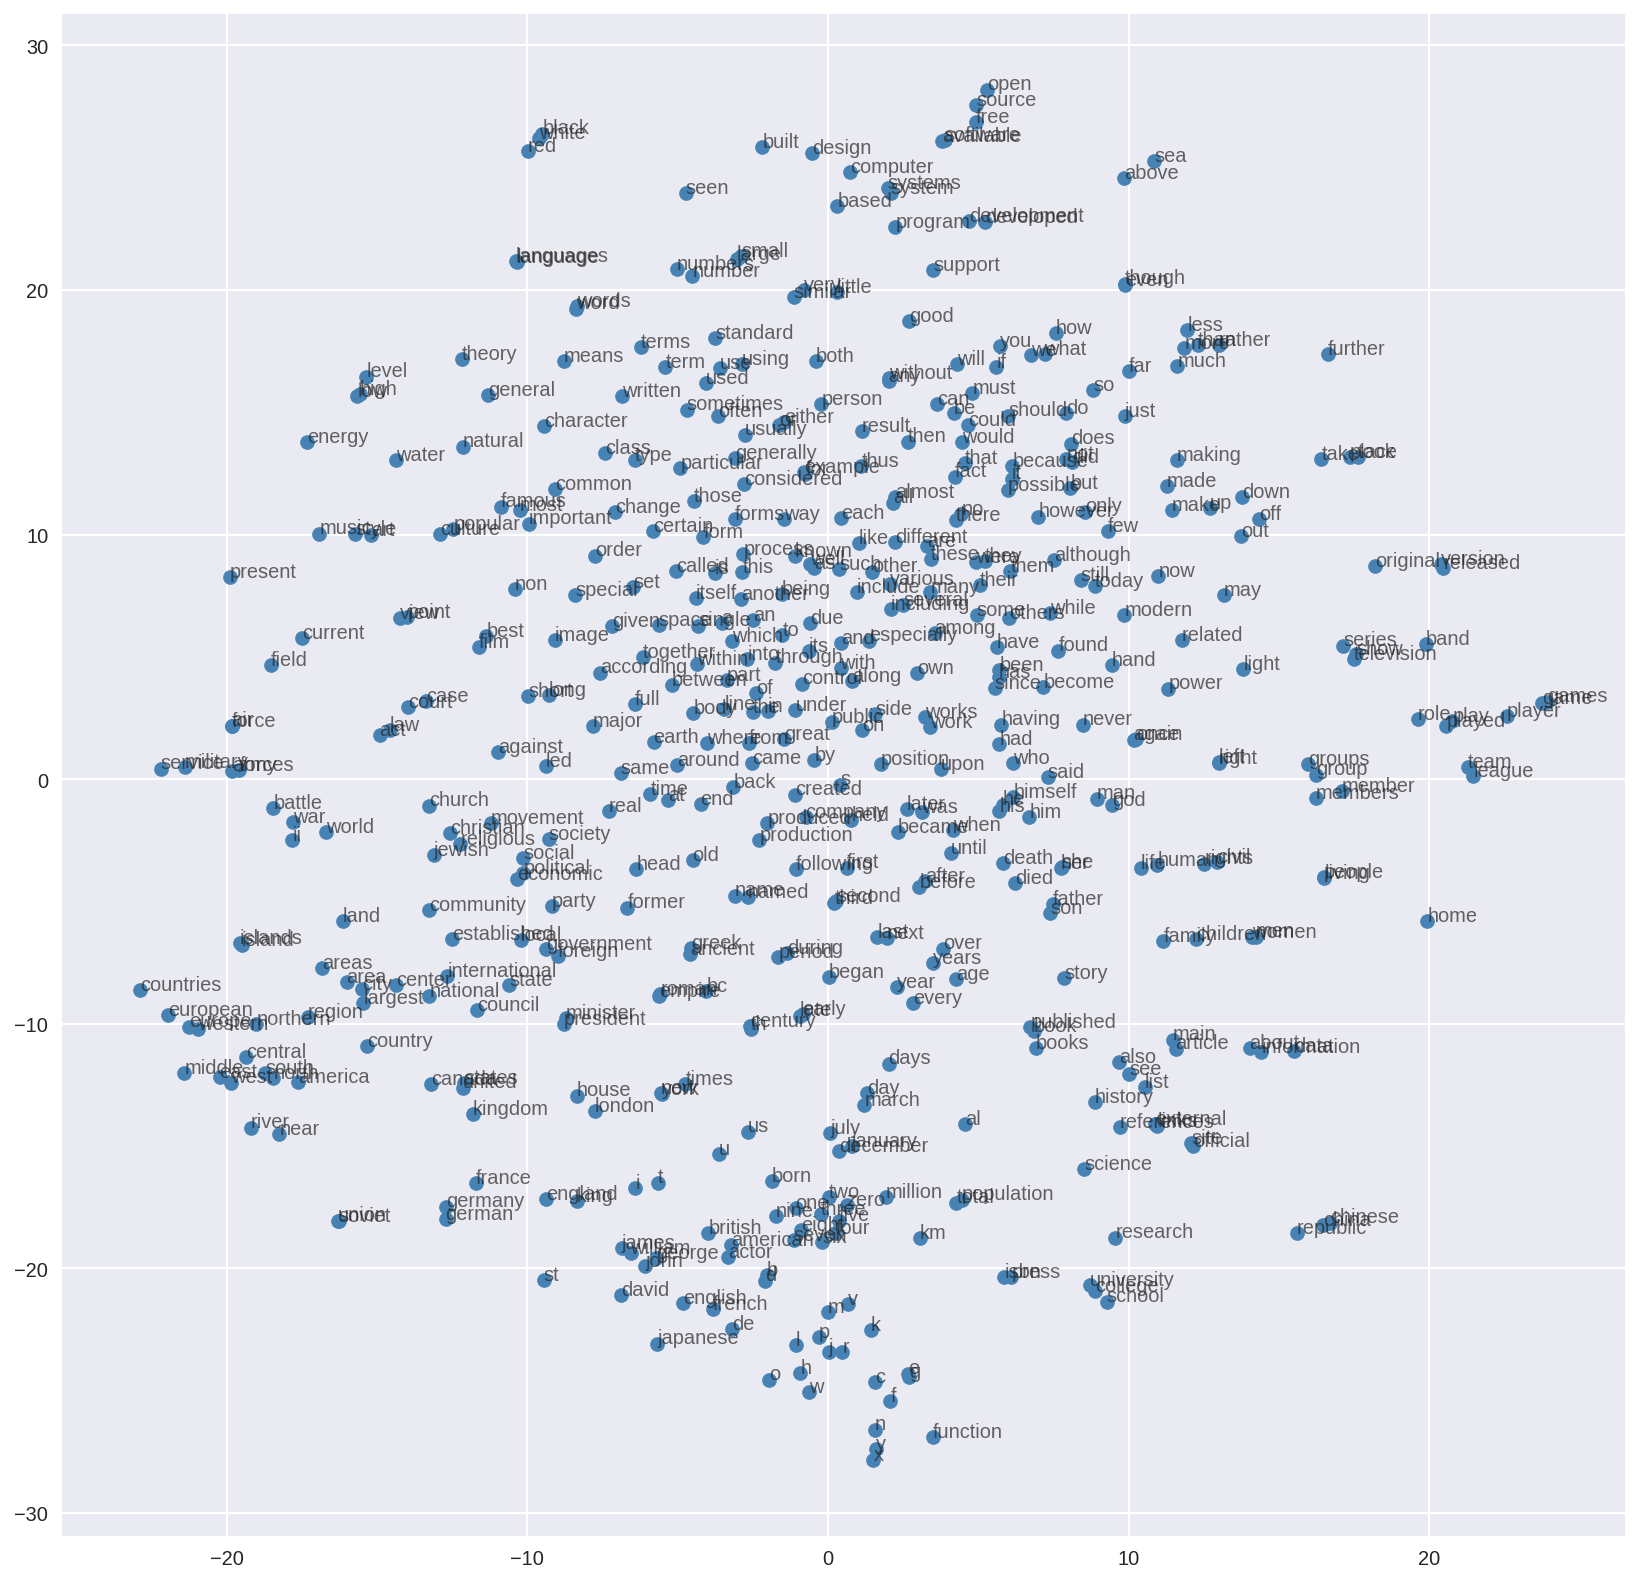

In [49]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)